In [1]:
EPOCHS = 15
BATCH_SIZE=32

In [2]:
import torch
from torch import nn
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [3]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [4]:
train_data.head()
# train_data['label']

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# reshape data into image format
train_data_label = train_data['label'].values.astype('float32')
train_data_image = train_data.drop('label', axis=1).values.astype('float32')
print(train_data_image.shape)
train_data_image_reshaped = train_data_image.reshape(-1, int(math.sqrt(train_data_image.shape[1])), int(math.sqrt(train_data_image.shape[1])))
print(train_data_image_reshaped.shape)

(42000, 784)
(28000, 28, 28)
(42000, 28, 28)


In [6]:


# print(train_data_image.values[5])
# plt.imshow(train_data_image.values[5].reshape(28, 28))
# print(train_data_label[5])

In [7]:

X_train, X_val, y_train, y_val = train_test_split(train_data_image_reshaped, train_data_label, test_size = 0.2, random_state=42)
X_train = X_train / 255
X_val = X_val / 255
# X_train_tensor = torch.tensor(X_train/255.0)
# X_val_tensor = torch.tensor(X_val/255.0)
# y_train_tensor = torch.tensor(y_train)
# y_val_tensor = torch.tensor(y_val)
# test_data_tensor = torch.tensor(test_data_reshaped)
print(X_train.shape)
print(X_val.shape)

(33600, 28, 28)
(8400, 28, 28)


In [8]:


# class model_0(nn.Module):
#     def __init__(self, input_shape, hidden_unit, output_shape):
#         super().__init__()
#         self.layer_stack = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=input_shape, out_features=hidden_unit),
#             nn.ReLU(),
#             nn.Linear(in_features=hidden_unit, out_features=hidden_unit*2),
#             nn.ReLU(),
#             nn.Linear(in_features=hidden_unit*2, out_features=hidden_unit),
#             nn.ReLU(),
#             nn.Linear(in_features=hidden_unit, out_features=output_shape),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         return self.layer_stack(x)



In [9]:
class model_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer, no activation needed for logits
        return x

In [10]:
class model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(torch.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout to prevent overfitting
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer, no activation for logits
        return x

In [11]:
model_0 = model_0()
model_1 = model_1()
loss_func = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
optimizer_1 = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [25]:
def train_model(model, train_loader, loss_func, optimizer):
    # print(type(train_loader))
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs[:1])
        # print(type(outputs[0]))
        # print(labels[:1])
        # print(type(labels[0]))
        # print(outputs.shape)
        # print(labels.shape)
        loss = loss_func(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    return epoch_loss, accuracy

def validate_model(model, val_loader, loss_func):
    # print(type(val_loader))
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_func(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = val_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    return epoch_loss, accuracy

In [29]:
class DigitDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X.iloc[idx].astype('float32')
        image = torch.tensor(image).unsqueeze(0)  # Add channel dimension

        if self.y is not None:
            label = torch.tensor(self.y[idx].astype('int64'))  # Cast labels to torch.long
            return image, label
        else:
            return image

In [14]:


train_dataset = DigitDataset(X_train, y_train)
val_dataset = DigitDataset(X_val, y_val)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# for idx, (images, labels) in enumerate(test_dataloader):
#     print(f"Processing batch {idx}")
#     # Run your training loop

In [16]:
model = model_1
optimizer = optimizer_1

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
Epoch 1/15: Train Loss: 0.2255, Train Acc: 92.96%, Val Loss: 0.0683, Val Acc: 97.77%
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
Epoch 2/15: Train Loss: 0.0763, Train Acc: 97.68%, Val Loss: 0.0416, Val Acc: 98.64%
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
Epoch 3/15: Train Loss: 0.0572, Train Acc: 98.29%, Val Loss: 0.0390, Val Acc: 98.80%
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
Epoch 4/15: Train Loss: 0.0500, Train Acc: 98.50%, Val Loss: 0.0378, Val Acc: 98.81%
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
Epoch 5/15: Train Loss: 0.0389, Train Acc: 98.86%, Val Loss: 0.0384, Val Acc: 98.87%
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.

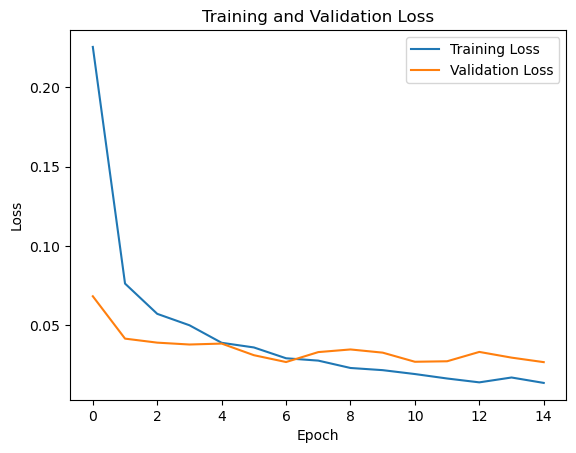

In [17]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_model(model, train_dataloader, loss_func, optimizer)
    val_loss, val_accuracy = validate_model(model, val_dataloader, loss_func)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{EPOCHS}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
          

# Plotting training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

    

In [30]:
test_data_reshaped = test_data.values.reshape(-1, int(math.sqrt(test_data.shape[1])), int(math.sqrt(test_data.shape[1])))
print(test_data_reshaped.shape)
test_dataset = DigitDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

(28000, 28, 28)


In [33]:
def predict(model, test_loader):
    print(type(test_dataloader))
    model.eval()
    predictions = []

    with torch.inference_mode():
        # print(test_dataloader)
        for images in test_loader:
            # print(test_dataloader)
            # print(image)
            outputs = model(images)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.numpy())

    return predictions 

In [35]:
# test_predictions = predict(model, test_dataloader)

# # Save predictions to submission file
# submission_df = pd.DataFrame({'ImageId': range(1, len(test_predictions) + 1), 'Label': test_predictions})
# submission_df.to_csv('submission.csv', index=False)